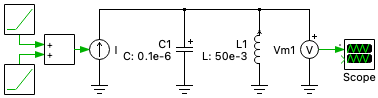

#### A circuit model of lossless resonant tank
Let's figure out how ACME defines ODEs of the underlining circuit by comparing them
to a known solution based on [1].

[1] David Klaffenbach, _A Quick Comparison of LTSpice and Julia DiffEq_, 2020, URL: https://klaff.github.io/LTSvDEQ_1.jl.html

In [1]:
using DifferentialEquations

I1(t) = t > 200e-6 ? 0.0 :
        t > 100e-6 ? 200e-3 - 200e-3t/200e-6 :
                              100e-3t/100e-6

function tank!(du, u, p, t)
    C1 = 0.1e-6
    L1 = 50e-3
    
    du .= [I1(t); 0.0] .+ 
          [0.0   -1.0/L1
           1.0/C1 0.0] * u 
    #du[1] = I1(t) - u[2]/L1
    #du[2] = u[1]/C1
end

u0 = [0.0, 0.0]
ts = (0.0, 1.0)
problem = ODEProblem(tank!, u0, ts)
solution = solve(problem, abstol=1e-9, reltol=1e-9)
nothing

In [2]:
using ACME

cir = @circuit begin
    i  = currentsource(),  [-] == gnd
    v  = voltageprobe(),   [-] == gnd, [+] == i[+]
    c1 = capacitor(0.1e-6),[2] == gnd, [1] == v[+]
    l1 = inductor(50e-3),  [2] == gnd, [1] == v[+]
end
nothing

Δt = 1e-6
model = DiscreteModel(cir, Δt)
t = range(0.0, 2e-3, step=Δt)
u = I1.(t)
y = run!(model, [ui for c in 1:1, ui in u])
nothing

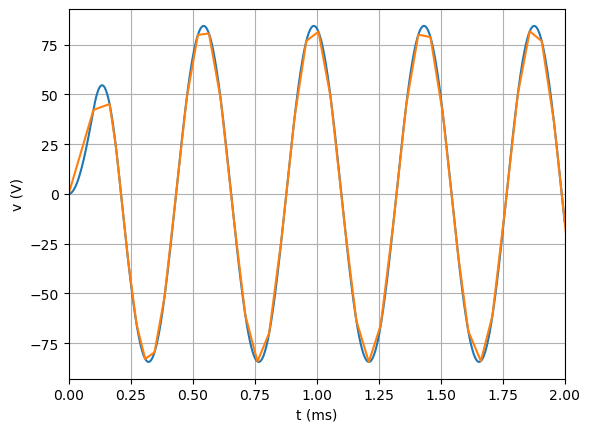

In [3]:
using PyPlot
plot(1e3t, y[:])
plot(1e3solution.t, [u[1]/0.1e-6 for u in solution.u])
xlabel("t (ms)")
ylabel("v (V)")
xlim([0.0, 2.0])
grid();

In [4]:
function freqcount(times, values)
    i = 1
    ncycles = 0
    tlast = 0
    t0 = 0
    while true
        if values[i+1] > 0 && values[i] <= 0
            t0 = times[i]
            break
        end
        i += 1
    end
    
    while i < lastindex(times) - 1
        i += 1
        if values[i+1] > 0 && values[i] <= 0
            ncycles += 1
            tlast = times[i]
        end
    end
    
    ncycles/(tlast-t0)
end
freqcount(t, y[:])

2265.0056625141565

In [5]:
ACME.nx(cir), ACME.nq(cir)

(2, 0)

In [6]:
ACME.mv(cir) .|> float

6×4 SparseArrays.SparseMatrixCSC{BigFloat, Int64} with 2 stored entries:
  ⋅    ⋅    ⋅        ⋅ 
  ⋅    ⋅    ⋅        ⋅ 
  ⋅    ⋅   1.0e-07   ⋅ 
  ⋅    ⋅    ⋅        ⋅ 
  ⋅    ⋅    ⋅       1.0
  ⋅    ⋅    ⋅        ⋅ 

In [7]:
ACME.mi(cir) .|> float

6×4 SparseArrays.SparseMatrixCSC{BigFloat, Int64} with 4 stored entries:
 -1.0   ⋅    ⋅    ⋅ 
   ⋅   1.0   ⋅    ⋅ 
   ⋅    ⋅    ⋅    ⋅ 
   ⋅    ⋅   1.0   ⋅ 
   ⋅    ⋅    ⋅    ⋅ 
   ⋅    ⋅    ⋅   0.050

In [8]:
ACME.mx(cir) .|> float

6×2 SparseArrays.SparseMatrixCSC{BigFloat, Int64} with 2 stored entries:
   ⋅     ⋅ 
   ⋅     ⋅ 
 -1.0    ⋅ 
   ⋅     ⋅ 
   ⋅     ⋅ 
   ⋅   -1.0

In [9]:
ACME.mxd(cir) .|> float

6×2 SparseArrays.SparseMatrixCSC{BigFloat, Int64} with 2 stored entries:
   ⋅     ⋅ 
   ⋅     ⋅ 
   ⋅     ⋅ 
 -1.0    ⋅ 
   ⋅   -1.0
   ⋅     ⋅ 

In [10]:
ACME.mu(cir) .|> float

6×1 SparseArrays.SparseMatrixCSC{BigFloat, Int64} with 1 stored entry:
 1.0
  ⋅ 
  ⋅ 
  ⋅ 
  ⋅ 
  ⋅ 

In [11]:
ACME.mq(cir) .|> float

6×0 SparseArrays.SparseMatrixCSC{BigFloat, Int64} with 0 stored entries

In [12]:
using SparseArrays
Tv, Ti = ACME.topomat(cir)
blockdiag(Tv, Ti)

4×8 SparseMatrixCSC{Int64, Int64} with 10 stored entries:
 -1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 -1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 -1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
  ⋅  ⋅  ⋅  ⋅  1  1  1  1

#### Custom and naive dual number implementation
We are defining a basic set of operations on dual numbers which allow for easy automatic differentiation.

In [13]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]